### Ensemble models

This lesson we aim to improve upon our decision tree models from last class and explore some alternative approaches to model building to overcome some of the drawbacks of the decision tree model. We will also discuss saving and resuse of models and explore a basic streamlit application.  

- [Download and Install VSCode](https://code.visualstudio.com/)
- [Install the Python extension](https://marketplace.visualstudio.com/items?itemName=ms-python.python)

**OBJECTIVES**

- Identify shortcomings of Decision Tree models
- Understand and Implement Ensemble models
- Understand and Implement Boosted models



In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay 
from sklearn.compose import make_column_transformer 
from sklearn.pipeline import Pipeline

### Decision Tree Review

In [9]:
#load data
heart = pd.read_csv('data/Heart.csv', index_col = 0)

In [10]:
#inspect
heart.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [11]:
#inspect
heart.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303 entries, 1 to 303
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Age        303 non-null    int64  
 1   Sex        303 non-null    int64  
 2   ChestPain  303 non-null    object 
 3   RestBP     303 non-null    int64  
 4   Chol       303 non-null    int64  
 5   Fbs        303 non-null    int64  
 6   RestECG    303 non-null    int64  
 7   MaxHR      303 non-null    int64  
 8   ExAng      303 non-null    int64  
 9   Oldpeak    303 non-null    float64
 10  Slope      303 non-null    int64  
 11  Ca         299 non-null    float64
 12  Thal       301 non-null    object 
 13  AHD        303 non-null    object 
dtypes: float64(2), int64(9), object(3)
memory usage: 35.5+ KB


In [12]:
#drop missing values
heart = heart.dropna()

<AxesSubplot: xlabel='AHD', ylabel='count'>

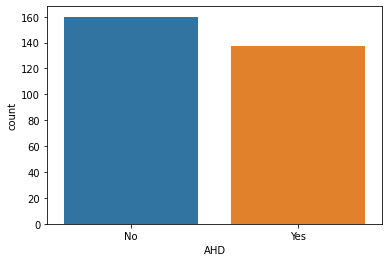

In [13]:
#target count
sns.countplot(data = heart, x = 'AHD')

### Train/Test Split

In [14]:
#define X
X = heart.drop('AHD', axis = 1)

In [15]:
#baseline
y = heart['AHD']
y.value_counts(normalize = True)

No     0.538721
Yes    0.461279
Name: AHD, dtype: float64

In [16]:
#define y (make it numeric)
y = np.where(y == 'No', 0, 1)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22)

### Preprocessing

- Encode categorical features

In [18]:
X.head(1)

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed


In [19]:
encoder = make_column_transformer((OneHotEncoder(), ['ChestPain', 'Thal']),
                                  remainder = 'passthrough',
                                  verbose_feature_names_out=False)

### Decision Tree

To begin, we use a Decision Tree to model the data.

In [20]:
pipe = Pipeline([('preprocess', encoder),
                 ('model', DecisionTreeClassifier())])

In [21]:
#fit 
pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['ChestPain', 'Thal'])],
                                   verbose_feature_names_out=False)),
                ('model', DecisionTreeClassifier())])

In [22]:
#accuracy
pipe.score(X_train, y_train)

1.0

In [23]:
#confusion matrix for train and test
pipe.score(X_test, y_test)

0.6933333333333334

**Reminder**

Use `.named_steps` to extract elements of pipeline -- here we want the `preprocess` step and to use the `get_feature_names_out` method to extract feature names.

In [24]:
#get feature names after transformations
pipe.named_steps['preprocess'].get_feature_names_out()

array(['ChestPain_asymptomatic', 'ChestPain_nonanginal',
       'ChestPain_nontypical', 'ChestPain_typical', 'Thal_fixed',
       'Thal_normal', 'Thal_reversable', 'Age', 'Sex', 'RestBP', 'Chol',
       'Fbs', 'RestECG', 'MaxHR', 'ExAng', 'Oldpeak', 'Slope', 'Ca'],
      dtype=object)

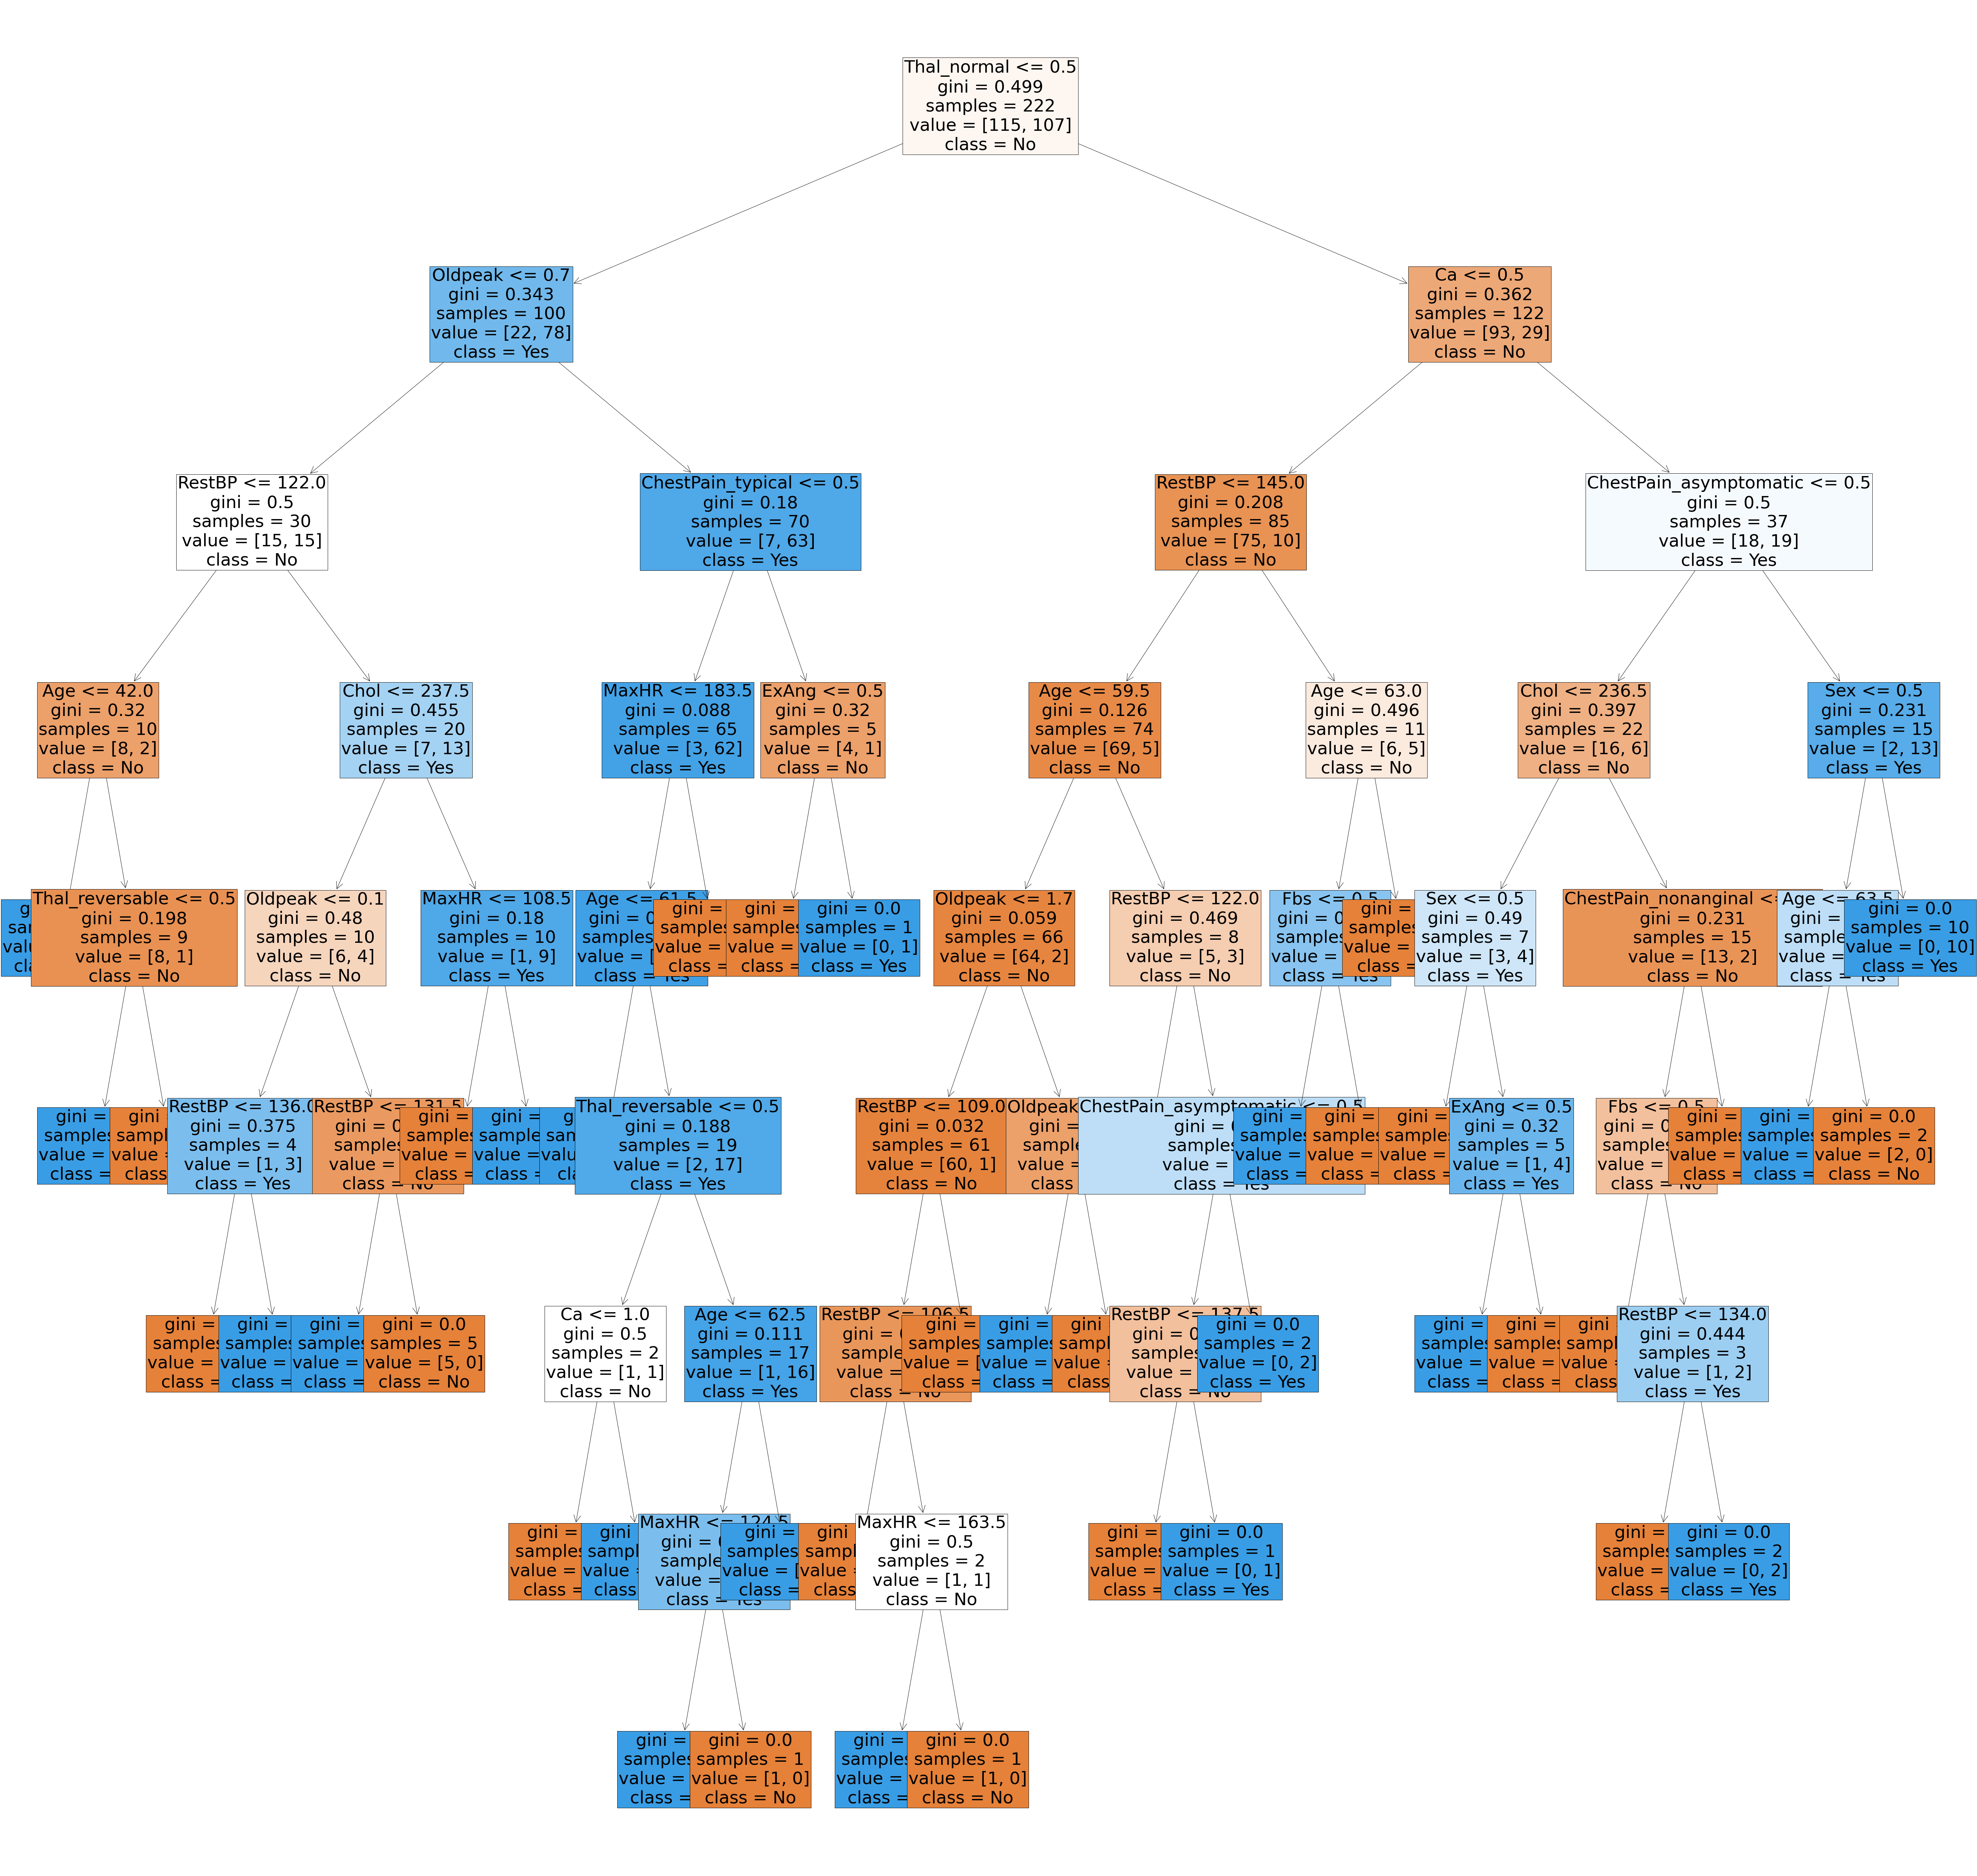

In [25]:
#visualize the tree
plt.figure(figsize = (100, 100))
plot_tree(pipe.named_steps['model'], 
          feature_names=pipe.named_steps['preprocess'].get_feature_names_out(),
          fontsize = 50,
          filled = True,
          class_names = ['No', 'Yes']);

### Issues with Decision Trees

When left alone, Decision Trees will overfit the data.  One approach to dealing with this would be to grid search different parameters and see if improved performance is possible.

**REMINDER**: When grid searching pipelines, name the step followed by two underscores followed by the parameter that you want to search.

In [26]:
#decision tree parameters
params = {'model__max_depth': [2, 3, 4, 5],
          'model__min_samples_split': [2,3,4,5,6]}

In [27]:
#grid for searching
grid = GridSearchCV(pipe, param_grid = params, cv = 2)
grid.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('onehotencoder',
                                                                         OneHotEncoder(),
                                                                         ['ChestPain',
                                                                          'Thal'])],
                                                          verbose_feature_names_out=False)),
                                       ('model', DecisionTreeClassifier())]),
             param_grid={'model__max_depth': [2, 3, 4, 5],
                         'model__min_samples_split': [2, 3, 4, 5, 6]})

In [28]:
#train score
grid.score(X_train, y_train)

0.9504504504504504

In [29]:
#test score
grid.score(X_test, y_test)

0.6933333333333334

### Ensemble methods

One approach to improving our tree model is to consider it alongside other models we have already discussed and form a voting block for the models.  Here, each model is allowed a vote on the prediction.  Scikitlearn implements this idea with a `VotingClassifier` model.



In [30]:
from sklearn.ensemble import VotingClassifier, BaggingClassifier

In [31]:
#voting approach
voter = VotingClassifier([('tree1', DecisionTreeClassifier(max_depth = 2)),
                          ('tree2',DecisionTreeClassifier(max_depth = 5)),
                          ('tree3',DecisionTreeClassifier(min_samples_split=5))])
vote_pipe = Pipeline([('preprocess', encoder),
                      ('model', voter)])

In [32]:
#fit it
vote_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['ChestPain', 'Thal'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 VotingClassifier(estimators=[('tree1',
                                               DecisionTreeClassifier(max_depth=2)),
                                              ('tree2',
                                               DecisionTreeClassifier(max_depth=5)),
                                              ('tree3',
                                               DecisionTreeClassifier(min_samples_split=5))]))])

In [33]:
vote_pipe.score(X_train, y_train)

0.963963963963964

In [34]:
vote_pipe.score(X_test, y_test)

0.7333333333333333

### Bagging Classifier

Building on the earlier ideas and taking them one step further, perhaps we build an ensemble of models on different samples of the data.  One such approach is referred to as **BAGGING**. Here, the samples are created with replacement -- **BOOTSTRAP** -- and the results are aggregated.  In classification this will be a vote either based on predictions or probabilities.

- **BOOTSTRAP**:  "*Bootstrapping is any test or metric that uses random sampling with replacement (e.g. mimicking the sampling process), and falls under the broader class of resampling methods*."

- **BAGGING**: Aggregating bootstrapped models

- **HARD VOTING**: Using majority of predicted values when ensembling

- **SOFT VOTING**: Using probabilities to determine predictions from an ensemble

In [35]:
#bagging pipeline
bag_pipe = Pipeline([('preprocess', encoder),
                     ('model', BaggingClassifier())])

In [36]:
#fit
bag_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['ChestPain', 'Thal'])],
                                   verbose_feature_names_out=False)),
                ('model', BaggingClassifier())])

In [37]:
#train score
bag_pipe.score(X_train, y_train)

0.9864864864864865

In [38]:
#test score
bag_pipe.score(X_test, y_test)

0.7466666666666667

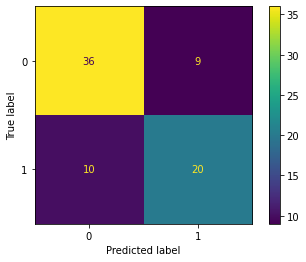

In [39]:
#confusion matrix on test
ConfusionMatrixDisplay.from_estimator(bag_pipe, X_test, y_test);

### Random Forests

*Random forests or random decision forests is an ensemble learning method for classification, regression and other tasks that operates by constructing a multitude of decision trees at training time. For classification tasks, the output of the random forest is the class selected by most trees. For regression tasks, the mean or average prediction of the individual trees is returned.*

The main difference to bagging is that we are also sampling features!

In [40]:
# import
from sklearn.ensemble import RandomForestClassifier

In [41]:
# pipeline
forest_pipe = Pipeline([('preprocess', encoder), 
                       ('model', RandomForestClassifier(max_depth = 2))])

In [42]:
# fit
forest_pipe.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(),
                                                  ['ChestPain', 'Thal'])],
                                   verbose_feature_names_out=False)),
                ('model', RandomForestClassifier(max_depth=2))])

In [43]:
# train score
forest_pipe.score(X_train, y_train)

0.8603603603603603

In [44]:
# test score
forest_pipe.score(X_test, y_test)

0.8266666666666667

In [45]:
models = [DecisionTreeClassifier(max_depth = 3), DecisionTreeClassifier(max_depth = 3)]

In [46]:
X.columns

Index(['Age', 'Sex', 'ChestPain', 'RestBP', 'Chol', 'Fbs', 'RestECG', 'MaxHR',
       'ExAng', 'Oldpeak', 'Slope', 'Ca', 'Thal'],
      dtype='object')

In [47]:
X1 = X[['Age', 'Sex']]
X2 = X[['RestBP', 'Chol']]
models[0].fit(X1, y)
models[1].fit(X2, y)

DecisionTreeClassifier(max_depth=3)

In [48]:
models[0].predict(X1)[:5]

array([1, 1, 1, 0, 0])

In [49]:
models[1].predict(X2)[:5]

array([1, 1, 0, 0, 0])

In [50]:
forest_pipe.named_steps['preprocess'].get_feature_names_out()

array(['ChestPain_asymptomatic', 'ChestPain_nonanginal',
       'ChestPain_nontypical', 'ChestPain_typical', 'Thal_fixed',
       'Thal_normal', 'Thal_reversable', 'Age', 'Sex', 'RestBP', 'Chol',
       'Fbs', 'RestECG', 'MaxHR', 'ExAng', 'Oldpeak', 'Slope', 'Ca'],
      dtype=object)

In [51]:
forest_pipe.named_steps['model'].feature_importances_

array([0.15959368, 0.02095375, 0.00631209, 0.00691848, 0.        ,
       0.18434863, 0.11990126, 0.05703062, 0.00562686, 0.00872917,
       0.00392702, 0.00038565, 0.00824053, 0.09640334, 0.06058379,
       0.10131025, 0.0363918 , 0.12334308])

In [52]:
pd.DataFrame({'features': forest_pipe.named_steps['preprocess'].get_feature_names_out(),
             'importance': forest_pipe.named_steps['model'].feature_importances_ }).sort_values(by = 'importance', ascending = False)

,features,importance
5,Thal_normal,0.184349
0,ChestPain_asymptomatic,0.159594
17,Ca,0.123343
6,Thal_reversable,0.119901
15,Oldpeak,0.101310
13,MaxHR,0.096403
14,ExAng,0.060584
7,Age,0.057031
16,Slope,0.036392
1,ChestPain_nonanginal,0.020954


### Boosted Models

An alternative to aggregating across models would be to iteratively update a model based on pervious performance.  This is what boosting does, and while we will gloss over most of the details -- the mechanism for updating the models is what determines the name of the boosted model.  

Scikitlearn implements an `AdaBoostClassifier` and `GradientBoostedClassifier` both iteratively update models based on prior performance.

In [53]:
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier

In [54]:
#adaboost
ada_pipeline = Pipeline([('preprocess', encoder), ('model', AdaBoostClassifier())])

In [55]:
# fit and score
ada_pipeline.fit(X_train, y_train)
ada_pipeline.score(X_test, y_test)

0.8133333333333334

In [56]:
#gradient boosting classifier


In [57]:
#fit and score


### `xgboost`

In [58]:
# !pip install xgboost

In [59]:
import xgboost as xgb

In [60]:
# instantiate classifier
xboost = xgb.XGBClassifier(n_estimators = 10, max_depth = 2)

In [61]:
# try with out of the box settings
boost_pipe = Pipeline([('encoder', encoder), 
                      ('model', xboost)])

In [62]:
# score it
boost_pipe.fit(X_train, y_train)
boost_pipe.score(X_train, y_train)

0.8648648648648649

In [63]:
boost_pipe.score(X_test, y_test)

0.8

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

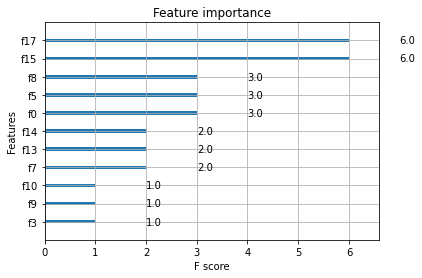

In [64]:
xgb.plot_importance(boost_pipe.named_steps['model'])

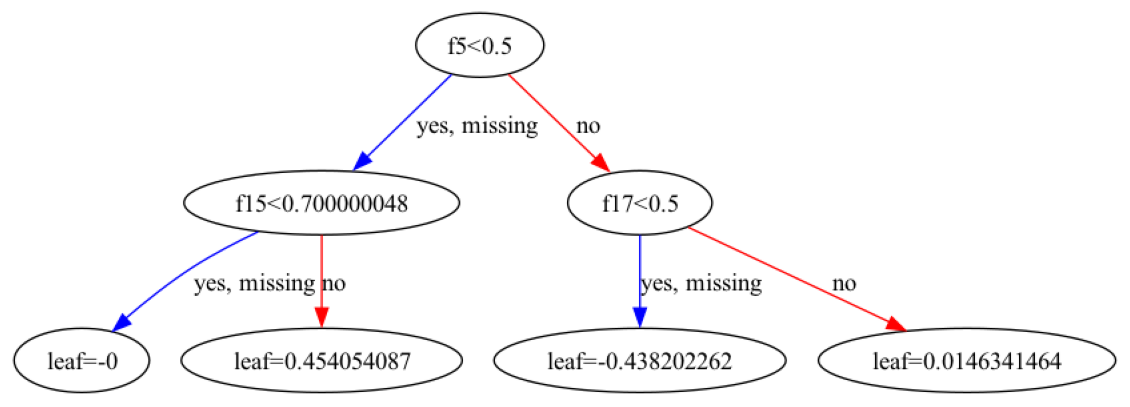

In [65]:
fig, ax = plt.subplots(figsize = (20, 20))
xgb.plot_tree(boost_pipe.named_steps['model'], ax = ax);

### Model Persistence

After building a model and identifying the optimal parameters its time to put it to use. The `pickle` module is one way to save and reuse python objects including sklearn models.  Below, we use the pickle module to save and load a list and sklearn model. 

In [66]:
import pickle

In [67]:
a = [1, 2, 3, 4]

In [68]:
#write out pickle file
with open('alist.pkl', 'wb') as f:
    pickle.dump(a, f)

In [69]:
#load in pickle file
with open('alist.pkl', 'rb') as f:
    thelist = pickle.load(f)

In [70]:
#here is the list again
thelist

[1, 2, 3, 4]

In [72]:
#save the boosted model as boost.pkl
heart.head()

,Age,Sex,ChestPain,RestBP,Chol,Fbs,RestECG,MaxHR,ExAng,Oldpeak,Slope,Ca,Thal,AHD
1,63,1,typical,145,233,1,2,150,0,2.3,3,0.0,fixed,No
2,67,1,asymptomatic,160,286,0,2,108,1,1.5,2,3.0,normal,Yes
3,67,1,asymptomatic,120,229,0,2,129,1,2.6,2,2.0,reversable,Yes
4,37,1,nonanginal,130,250,0,0,187,0,3.5,3,0.0,normal,No
5,41,0,nontypical,130,204,0,2,172,0,1.4,1,0.0,normal,No


In [73]:
X = heart[['Age', 'Sex', 'Slope']]
y = heart['AHD']
forest = RandomForestClassifier().fit(X, y)

In [75]:
with open('streamlit_example/forestmodel.pkl', 'wb') as f:
    pickle.dump(forest, f)

#### A Simple Application

Below is the code for a basic streamlit application.  This is a way to deploy and share your models.  For more options see the documentation [here](https://docs.streamlit.io/).

```python
import streamlit as st 
import numpy as np
import pickle

st.header('A Model for AHD')

st.write('Please enter the Age, Sex, and Slope information below.')

age = st.number_input('Age')
sex = st.number_input('Sex')
slope = st.number_input('Slope')

X = np.array([[age, sex, slope]])

with open('forestmodel.pkl', 'rb') as f:
    model = pickle.load(f)
    
pred = model.predict(X)

st.write(f'The model predicts {pred[0]}')
```

Once the app is created, you can run it by writing 

```
streamlit run app.py
```